#### **Hybrid Multimodal Vector Search or Hybrid AI Search for Smarter E-Commerce Product Discovery:**

---

## ***Project Overview***

Today's online shoppers expect more than just keyword matching.. Traditional e-commerce search often fails to connect customers with the right products when they use **descriptive language**, **subjective terms** like **"cozy"** or **"sleek,"** or **"seek a"** **specific visual feel** described in words.

This leads to **frustrated customers** and **missed sales opportunities**.

## Our Solution

We are introducing **Hybrid AI Search**, a powerful system built on the concept of **hybrid vector search**. This combines the **precision of traditional keyword search** (for exact matches like brand names) with the **intelligence of modern dense vector search** (which understands meaning and even visual characteristics from text descriptions).

The result is an **innovative solution** that revolutionizes product discovery, enabling customers to find products effortlessly using **exact terms**, **natural language**, or **visual descriptions**.







In [ ]:
!pip install gradio

In [ ]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client==3.1.0 pinecone-text \
                 pinecone-notebooks

Why use Pinecone ??
- Fully managed vector database
- Offers tools like keyword- based search
- Storing , indexing and querying high dimensional vectors

In [ ]:
from pinecone_notebooks.colab import Authenticate

Authenticate()

In [ ]:
import os
os.environ["PINECONE_API_KEY"] = "Your API key"


In [ ]:
from pinecone import Pinecone
from PIL import Image, ImageOps    # ✅ add this here
import numpy as np

# initialize connection to pinecone
api_key = os.environ.get('PINECONE_API_KEY')

# configure client
pc = Pinecone(api_key=api_key)

Setup index specification , by providing cloud and region where we want to deploy and name it

In [ ]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [ ]:
# choose a name for your index
index_name = "hybrid-image-search"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=512,
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

We load the dataset from Hugging Face .

"What is HuggingFace ??" . It is a central online platform for machine learning , acting as a collaboration hub for collaborating on AI models , datasets and applications.

split = "train" -- Hugging face splits into different subnets namely training (train) , testing (test) and validation.

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

Divide the data into 2 parts : images and metadata

"Why divide into 2 parts ??"

We divide into 2 parts so we can process them separately using the appropriate tools — deep learning models for images, and text encoders or dataframes for text.

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

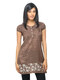

In [ ]:
# display a product image
images[900]

In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

In [ ]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 :

It is a ranking function used by search engines to estimate the relevance of documents to a given query. It ranks documents based on :

Term Frequency : How often a query word appear in the document

Inverse Document Frequency : How rare the query term is across documents

Document Normalization : Shorter documents are more likely to be relevant.



In [ ]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [ ]:

metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

Converts titles into sparse vectors
Creates query and document vectors from text.

In [ ]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [ ]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

CLIP (Contrastive Language-Image Pre-Training) :
- Learns the joint representation of images and their corresponding textual descriptions.
- Understanding the relation between visual and textual data using "zero-shot".

Sentence Transformer :
- Load pre-trained models for encoding text into vecotr embeddings

Why CLIP??

- We want to build a search engine where users can search fashion products using : Text , Image or a combination of both

To achieve this, we need to convert both text and images into meaningful numerical representations (called vectors or embeddings) so we can compare them.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


SentenceTransformer(
  (0): CLIPModel()
)

Dense Vectors :
- Dense vectors (aka embeddings) are numeric representations of images or text that capture meaning or visual features.

Why create dense vectors for product and batch

- Dense vectors are created in batches to avoid memory overload, speed up processing, and make the system scalable and efficient.

In [ ]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

# Upsert Dataset

In [ ]:
# from tqdm.auto import tqdm

# batch_size = 200

# for i in tqdm(range(0, len(fashion), batch_size)):
#     # find end of batch
#     i_end = min(i+batch_size, len(fashion))
#     # extract metadata batch
#     meta_batch = metadata.iloc[i:i_end]
#     meta_dict = meta_batch.to_dict(orient="records")
#     # concatinate all metadata field except for id and year to form a single string
#     meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
#     # extract image batch
#     img_batch = images[i:i_end]
#     # create sparse BM25 vectors
#     sparse_embeds = bm25.encode_documents([text for text in meta_batch])
#     # create dense vectors
#     dense_embeds = model.encode(img_batch).tolist()
#     # create unique IDs
#     ids = [str(x) for x in range(i, i_end)]

#     upserts = []
#     # loop through the data and create dictionaries for uploading documents to pinecone index
#     for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
#         upserts.append({
#             'id': _id,
#             'sparse_values': sparse,
#             'values': dense,
#             'metadata': meta
#         })
#     # upload the documents to the new hybrid index
#     index.upsert(upserts)

# # show index description after uploading the documents
# index.describe_index_stats()

Passing Query :

- Returns all the top 14 closest matches using both sparse and dense vectors.

In [ ]:
def search_fashion(query: str, alpha: float):
    sparse = bm25.encode_queries(query)
    dense = model.encode(query).tolist()
    hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
    result = index.query(
        top_k=8,
        vector=hdense,
        sparse_vector=hsparse,
        include_metadata=True
    )
    imgs = [images[int(r["id"])] for r in result["matches"]]
    return imgs


In [ ]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>]

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


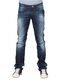
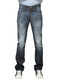
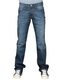
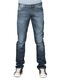
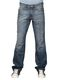
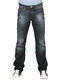
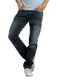
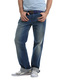
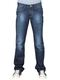
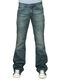
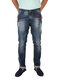
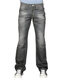
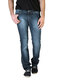
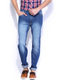

In [ ]:
display_result(imgs)

It's possible to prioritize our search based on sparse vs. dense vector results. To do so, we scale the vectors, for this we'll use a function named ` hybrid_scale `.

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):

    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


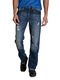
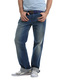
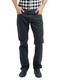
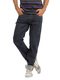
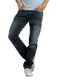
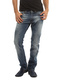
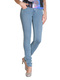
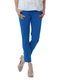
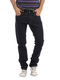
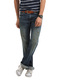
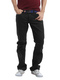
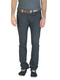
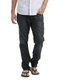
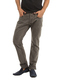

In [ ]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Grey Jeans



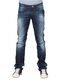
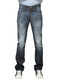
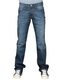
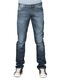
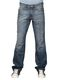
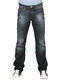
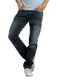
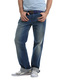
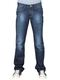
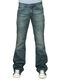
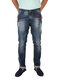
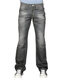
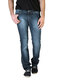
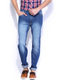

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Lio Blue Jeans
Locomotive Men Rafe Blue Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Locomotive Men Barney Grey Jeans
Wrangler Men Blue Skanders Jeans
John Players Men Blue Jeans



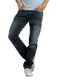
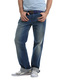
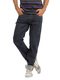
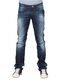
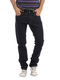
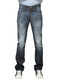
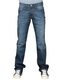
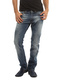
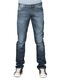
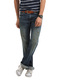
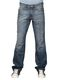
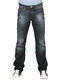
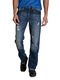
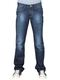

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Radley Blue Jeans
French Connection Men Navy Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cam Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
Locomotive Men Ian Blue Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Lio Blue Jeans



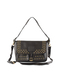
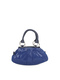
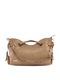
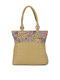
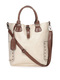
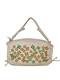
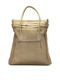
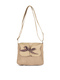
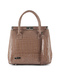
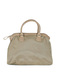
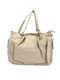
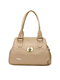
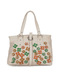
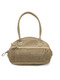

In [ ]:
query = "small beige handbag for women"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


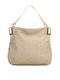
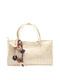
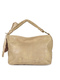
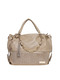
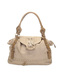
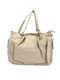
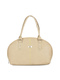
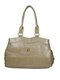
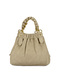
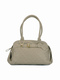
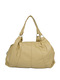
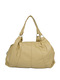
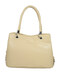
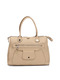

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Rocky S Women Beige Handbag
Kiara Women Beige Handbag
Baggit Women Beige Handbag
Lino Perros Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Murcia Women Beige Handbag
Murcia Women Hahk Beige Handbags
Rocia Women Beige Handbag
Baggit Women Beige Handbag
Murcia Women Emma Beige Handbags
Murcia Women Emma Beige Handbags
Murcia Women Hddcs Beige Handbags
French Connection Women Beige Handbag



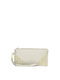
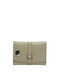
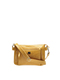
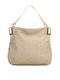
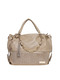
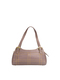
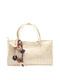
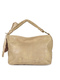
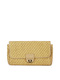
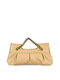
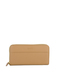
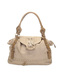
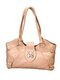
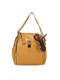

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

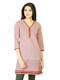

In [ ]:
images[36254]

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Mother Earth Women Beige Printed Kurta
Folklore Women Red Printed Kurta
Mother Earth Women Orange  Kurta
Vishudh Women Brown Printed Kurta
Aurelia Women Printed Red Kurti
Fabindia Women Orange Abstract Print Kurta
W Women Printed Purple Kurtas
Vishudh Women Red Printed Kurta
Fabindia Women Printed Red Kurta
Aurelia Women Printed Red Kurtis
W Women Printed White Kurtas
BIBA Women Printed Blue Kurta
Aneri Women Zubeda Blue Kurta
W Women Printed Red Kurtas



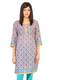
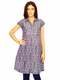
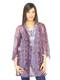
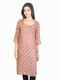
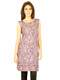
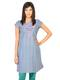
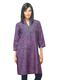
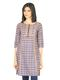
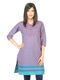
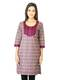
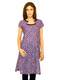
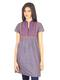
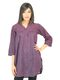
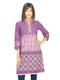

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


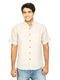

In [ ]:
images[36256]


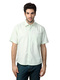
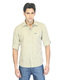
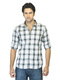
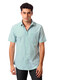
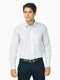
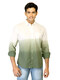
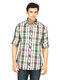
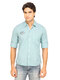
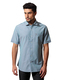
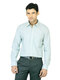
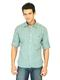
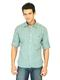
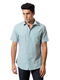
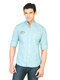

In [ ]:
query = "kids red watch"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


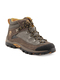
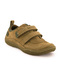
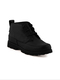
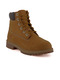
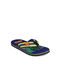
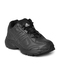
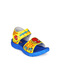
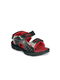
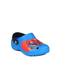
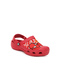
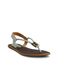
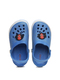
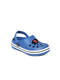
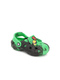

In [ ]:
query = "kids boys footwear"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Timberland Kids Boys Brown Casual Shoes
Timberland Kids Boys Brown Casual Shoes
Timberland Kids Boys Casual Black Casual Shoes
Timberland Kids Boys Casual Brown Casual Shoes
Kids Ville Boys Blue Flip Flops
ADIDAS Kids Boys Duramo Synthetic Black Sports Shoes
Marvel Boys Yellow Sandals
Marvel Boys Black Sandals
Marvel Boys Blue Slippers
Marvel Boys Red Sandals
Catwalk White footwear Flats
Marvel Boys Blue Spiderman Clogs
Marvel Boys Blue Spiderman Clogs
Marvel Boys Green Hero Sandals


In [ ]:
!pip install pillow


In [ ]:
from PIL import Image, ImageOps
import numpy as np  # needed for fromarray

def extract_metadata_filters(query: str):
    query_lower = query.lower()
    gender = None
    category = None
    subcategory = None
    color = None

    # --- Gender Mapping ---
    gender_map = {
        "men": "Men", "man": "Men", "mens": "Men", "mans": "Men",
        "women": "Women", "woman": "Women", "womens": "Women",
        "boys": "Boys", "boy": "Boys",
        "girls": "Girls", "girl": "Girls",
        "kids": "Kids", "unisex": "Unisex"
    }
    for term, mapped_value in gender_map.items():
        if term in query_lower:
            gender = mapped_value
            break

    # --- ArticleType / Category Mapping ---
    category_map = {
        "shirt": "Shirts",
        "tshirt": "Tshirts", "t-shirt": "Tshirts",
        "jeans": "Jeans",
        "watch": "Watches",
        "kurta": "Kurtas",
        "dress": "Dresses", "dresses": "Dresses",
        "trousers": "Trousers", "pants": "Trousers",
        "shorts": "Shorts",
        "footwear": "Footwear",
        "shoes": "Footwear",
        "fashion": "Apparel"  # fallback for broad "fashion" queries
    }
    for term, mapped_value in category_map.items():
        if term in query_lower:
            category = mapped_value
            break

    # --- SubCategory Mapping ---
    subCategory_list = [
        "Accessories", "Apparel Set", "Bags", "Bath and Body", "Beauty Accessories",
        "Belts", "Bottomwear", "Cufflinks", "Dress", "Eyes", "Eyewear", "Flip Flops",
        "Fragrance", "Free Gifts", "Gloves", "Hair", "Headwear", "Home Furnishing",
        "Innerwear", "Jewellery", "Lips", "Loungewear and Nightwear", "Makeup",
        "Mufflers", "Nails", "Perfumes", "Sandal", "Saree", "Scarves", "Shoe Accessories",
        "Shoes", "Skin", "Skin Care", "Socks", "Sports Accessories", "Sports Equipment",
        "Stoles", "Ties", "Topwear", "Umbrellas", "Vouchers", "Wallets", "Watches",
        "Water Bottle", "Wristbands"
    ]

    # explicitly handle topwear
    if "topwear" in query_lower or "top" in query_lower:
        subcategory = "Topwear"
    else:
        for subcat in subCategory_list:
            if subcat.lower() in query_lower:
                subcategory = subcat
                break

    # --- Color Extraction ---
    colors = [
        "red", "blue", "green", "yellow", "black", "white",
        "orange", "pink", "purple", "brown", "grey", "beige"
    ]
    for c in colors:
        if c in query_lower:
            color = c.capitalize()
            break

    # --- Invalid pair detection ---
    invalid_pairs = {
        ("Men", "Dresses"), ("Men", "Skirts"), ("Men", "Sarees"),
        ("Boys", "Dresses"), ("Boys", "Skirts"), ("Boys", "Sarees"),
        ("Girls", "Boxers"), ("Men", "Heels")
    }
    if (gender, category) in invalid_pairs:
        print(f"⚠️ Invalid pair: {gender} + {category} detected, dropping gender filter to allow results")
        gender = None

    # --- Gender fallback logic for broad queries ---
    if gender and not category and not subcategory:
        category = "Apparel"  # treat as generic clothing

    return gender, category, subcategory, color


def search_fashion(query: str, alpha: float):
    gender, category, subcategory, color = extract_metadata_filters(query)

    # --- Build Pinecone filter ---
    filter = {}
    if gender:
        filter["gender"] = gender
    if category:
        filter["articleType"] = category
    if subcategory:
        filter["subCategory"] = subcategory
    if color:
        filter["baseColour"] = color

    # --- Create hybrid vectors ---
    sparse = bm25.encode_queries(query)
    dense = model.encode(query).tolist()
    hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)

    # --- Pinecone search ---
    result = index.query(
        top_k=12,
        vector=hdense,
        sparse_vector=hsparse,
        include_metadata=True,
        filter=filter if filter else None
    )

    # --- Process results for display ---
    imgs_with_captions = []
    for r in result["matches"]:
        idx = int(r["id"])
        img = images[idx]
        meta = r.get("metadata", {})
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        padded = ImageOps.pad(img, (256, 256), color="white")
        caption = str(meta.get("productDisplayName", "Unknown Product"))
        imgs_with_captions.append((padded, caption))

    return imgs_with_captions


In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("# 🛍️ Fashion Product Hybrid Search")

    query = gr.Textbox(label="Enter your fashion search query")
    alpha = gr.Slider(0, 1, value=0.5, label="Hybrid Weight (alpha: 0=sparse, 1=dense)")
    search_btn = gr.Button("Search")

    gallery = gr.Gallery(label="Search Results",columns=8, height="40vh")

    def run_search(q, a):
        return search_fashion(q, a)

    search_btn.click(run_search, inputs=[query, alpha], outputs=gallery)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fb4cfa0b516e80d744.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
metadata.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
product_name = "Fabindia Men Striped Green Shirt"

row = metadata[metadata['productDisplayName'] == product_name]

if row.empty:
    print("Product not found")
else:
    print(row)
    idx = row.index[0]
    print(f"The index of '{product_name}' is {idx}")




      id gender masterCategory subCategory articleType baseColour  season  \
6  30805    Men        Apparel     Topwear      Shirts      Green  Summer   

     year   usage                productDisplayName  
6  2012.0  Ethnic  Fabindia Men Striped Green Shirt  
The index of 'Fabindia Men Striped Green Shirt' is 6



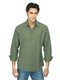
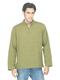
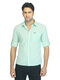
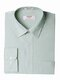
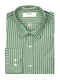
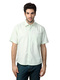
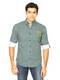
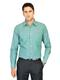
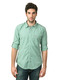
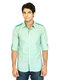
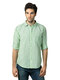
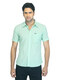
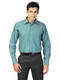
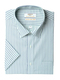

In [ ]:
query = "Fabindia Men Striped Green Shirt"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Fabindia Men Striped Green Shirt
Fabindia Men Striped Green Kurta
Wrangler Men Green Striped Shirt
Arrow Men Stripes Green Shirts
Arrow Men Green Striped Shirt
Scullers Men Striped Green Shirt
Locomotive Men Stripes Green Shirts
Belmonte Men Stripes Green Shirts
Basics Men Green Striped Shirt
Probase Men Stripes Green Shirt
Basics Men Green Striped Shirt
Wrangler Men Striped Green Shirt
Genesis Men Stripes Green Shirts
Arrow Men Green Striped Shirt


In [ ]:
def get_product_metadata_by_id(product_id: str):
        resp = index.fetch(ids=[product_id])
        if product_id in resp['vectors']:
            meta = resp['vectors'][product_id]['metadata']
            return meta




# Example usage:
product_id = "30805"
metadata = get_product_metadata_by_id(product_id)
if metadata:
    print(metadata)




{'articleType': 'Tshirts', 'baseColour': 'White', 'gender': 'Men', 'id': 1575.0, 'masterCategory': 'Apparel', 'productDisplayName': 'Kipsta Men Sports White T-shirt', 'season': 'Summer', 'subCategory': 'Topwear', 'usage': 'Casual', 'year': 2011.0}


In [ ]:
# Assuming 'metadata' is your pandas DataFrame containing product information

product_name = "Fabindia Men Striped Green Shirt"

# Find the row(s) where 'productDisplayName' matches the desired product_name
row = metadata[metadata['productDisplayName'] == product_name]

if row.empty:
    print(f"Product '{product_name}' not found in the metadata.")
else:
    # If multiple rows match, take the first one
    product_metadata = row.iloc[0] # .iloc[0] gets the first matching row as a pandas Series

    print(f"Metadata for product: '{product_name}'\n")
    print(product_metadata) # This will print all columns (metadata) for that specific product

    # If you also want the original index from the DataFrame:
    idx = row.index[0]
    print(f"\nThe original index of '{product_name}' is {idx}")

# The line 'if metadata: print(metadata)' would print the entire DataFrame,
# which is usually not what's intended when searching for a specific product.
# I've removed it as it was likely causing confusion and printing too much.

Metadata for product: 'Fabindia Men Striped Green Shirt'

id                                               30805
gender                                             Men
masterCategory                                 Apparel
subCategory                                    Topwear
articleType                                     Shirts
baseColour                                       Green
season                                          Summer
year                                            2012.0
usage                                           Ethnic
productDisplayName    Fabindia Men Striped Green Shirt
Name: 6, dtype: object

The original index of 'Fabindia Men Striped Green Shirt' is 6


In [ ]:
import pandas as pd

product_id = "30805"
metadata = get_product_metadata_by_id(product_id)

if metadata:
    metadata_df = pd.DataFrame([metadata])
    print(metadata_df.head())


  articleType baseColour gender      id masterCategory  \
0     Tshirts      White    Men  1575.0        Apparel   

                productDisplayName  season subCategory   usage    year  
0  Kipsta Men Sports White T-shirt  Summer     Topwear  Casual  2011.0  


In [ ]:
import pandas as pd

def get_product_metadata_by_id(product_id: str):
    try:
        resp = index.fetch(ids=[product_id])
        if product_id in resp['vectors']:
            return resp['vectors'][product_id]['metadata']
        else:
            return None
    except Exception:
        return None

# Example usage:
product_id = "30805"
metadata = get_product_metadata_by_id(product_id)
if metadata:
    df = pd.DataFrame([metadata])
    print(df)


  articleType baseColour gender      id masterCategory  \
0     Tshirts      White    Men  1575.0        Apparel   

                productDisplayName  season subCategory   usage    year  
0  Kipsta Men Sports White T-shirt  Summer     Topwear  Casual  2011.0  


In [ ]:
import nbformat

# Load the notebook you are in
path = '/content/AI_hybrid_search.ipynb'  # change this if needed
with open(path) as f:
    nb = nbformat.read(f, as_version=4)

# Remove all metadata.widgets safely
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

# Also remove any metadata.widgets in each cell
for cell in nb.cells:
    if "widgets" in cell.get("metadata", {}):
        del cell["metadata"]["widgets"]

# Save it back
with open(path, "w") as f:
    nbformat.write(nb, f)

print("Cleaned notebook metadata, you can now push to GitHub.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/AI_hybrid_search.ipynb'

In [ ]:
import nbformat
import os
import glob

# Attempt to find the notebook file dynamically
# Colab notebooks are usually in the /content/ directory
# We'll look for .ipynb files and assume it's the one being currently executed.
# This is not foolproof but more robust than a hardcoded path.
notebook_files = glob.glob('/content/*.ipynb')

notebook_path = None
if notebook_files:
    # Assuming the most recently modified or only .ipynb file is the current one
    # This might need adjustment if there are multiple .ipynb files in /content/
    notebook_path = max(notebook_files, key=os.path.getmtime)
    print(f"Attempting to load notebook from: {notebook_path}")
else:
    print("Error: Could not find any .ipynb files in /content/ directory.")

# Load the notebook if a path was found
nb = None
if notebook_path:
    try:
        with open(notebook_path) as f:
            nb = nbformat.read(f, as_version=4)
    except Exception as e:
        print(f"Error loading notebook from {notebook_path}: {e}")


# Remove all metadata.widgets safely if notebook was loaded
if nb:
    if "widgets" in nb["metadata"]:
        del nb["metadata"]["widgets"]

    # Also remove any metadata.widgets in each cell
    for cell in nb.cells:
        if "widgets" in cell.get("metadata", {}):
            del cell["metadata"]["widgets"]

    # Save it back
    try:
        with open(notebook_path, "w") as f:
            nbformat.write(nb, f)
        print(f"Cleaned notebook metadata for {notebook_path}. You can now push to GitHub.")
    except Exception as e:
         print(f"Error saving the cleaned notebook to {notebook_path}: {e}")
else:
    print("Notebook could not be loaded or found. Metadata cleaning skipped.")

Error: Could not find any .ipynb files in /content/ directory.
Notebook could not be loaded or found. Metadata cleaning skipped.


In [2]:
!pip install nbformat

In [3]:
import nbformat

path = "AI_hybrid_search.ipynb"

try:
    with open(path, encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)
    nbformat.validate(nb)
    print("Notebook is valid JSON ✅")
except Exception as e:
    print("Notebook is INVALID ❌:", e)


Notebook is INVALID ❌: [Errno 2] No such file or directory: 'AI_hybrid_search.ipynb'
